<a href="https://colab.research.google.com/github/juancn95/saturdaysAI_titanic_challenge/blob/pdt_1/SaturdaysAI_titanic_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **El desafío del Titanic**
---

## **Visión general**
El hundimiento del Titanic es uno de los naufragios más infames de la historia. El 15 de abril de 1992, durante su viaje de inauguración, el considerado "no hundible" RMS Titanic, se hundió luego de colisionar con un iceberg. Desafortunadamente, no hubieron suficientes salvavidas para cada uno de los pasajeros a bordo, resultando en la muerte de más de 1502 personas, entre pasajeros y tripulación, para un total de 2224. 

Aunque habían elementos de buena suerte involucrados en la supervivencia, parece que ciertos grupos de personas tuvieron mayor probabilidad de sobrevivir que otras. 

En esta competencia, usando los datos de los pasajeros, tales como nombre, género, clase socio-económica, entre otros; se deberá construir un modelo predictivo que responda a la siguiente pregunta: ¿Cuáles fueron los grupos de personas con mayor probabilidad de sobrevivir? 

## **Objetivo**
- Predecir si cada uno de los pasajeros sobrevivió (1) o  no (0), tras el hundimiento del barco Titanic

## **Métrica**

La puntuación del modelo será el **porcentaje de pasajeros correctamente predecidos**, conocido también como **precisión**.

## **Formato del archivo de entrega**
El formato será un archivo de extensión `.csv` con 418 entradas con su correspondiente fila de encabezado, y solo deberá contener las columnas `PassengerID` y `Survived`. Si el archivo tiene una columna o fila extra, se remitirá un error. 

`PassengerID`: Ordenado en cualquier orden, sea ascendente o descendente. 

`Survived`: Contiene la **predicción binaria**: 1 para sobrevivió, 0 para fallecido.



# **Inicio**

## **Depencias**
**Manipulación de datos**: `pandas` `numpy` `scikit-learn`

**Visualización de datos**: `matplotlib` `seaborn` 

**Estadísticos**: `phik`<font size="2"><sup>1</sup></font> 

<font size="2"><b>[Phik](https://arxiv.org/abs/1811.11440) </b>
<sup>1</sup> es un coeficiente de correlación basado en varios refinamientos a la prueba de hipótesis de Pearson de independencia de dos variables: categóricas, ordinales y de intervalo.</font>

In [2]:
!pip install phik

     |████████████████████████████████| 614kB 2.8MB/s 
     |████████████████████████████████| 256kB 47.7MB/s 
     |████████████████████████████████| 307kB 44.0MB/s 
     |████████████████████████████████| 215kB 74kB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 747kB 38.7MB/s 
  Created wheel for wrapt: filename=wrapt-1.11.2-cp36-cp36m-linux_x86_64.whl size=67531 sha256=221f197de95e8aea7be829e152c7c366e16185945cc5e5fe72bd09ac9057b7fd
  Stored in directory: /root/.cache/pip/wheels/d7/de/2e/efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
Successfully built wrapt
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully u

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
from phik import resources, report

## **Carga de datos desde AWS**


In [0]:
df = pd.read_csv('https://saturday-ai.s3-sa-east-1.amazonaws.com/titanic/train.csv')
df_test = pd.read_csv('https://saturday-ai.s3-sa-east-1.amazonaws.com/titanic/test.csv')
df_sub = pd.read_csv('https://saturday-ai.s3-sa-east-1.amazonaws.com/titanic/gender_submission.csv')

### **Descripción de variables**

>Variable | Definición | Clave | Tipo de variable
>--- | --- | --- | ---
>`PassengerId` | ID || Cadena
`Survived` | Supervivencia | 0: No, 1 : Sí | Categórica de tipo dicotómico
`Pclass` | Clase de boleto | 1: 1st, 2: 2nd, 3: 3rd | Categórica de tipo ordinal
`Name` | Nombre del pasajero | | Cadena
`Sex` | Edad | | Cuantitativa de tipo continuo
`SibSp` | No. hermanos / cónyuges abordo || Cuantitativa de tipo discreto
`Parch` | No. de padres / niños abordo ||Cuantitativa de tipo discreto
`Ticket` | Número del ticket|| Cadena
`Fare` | Tarifa del pasajero continuos || Cuantitiva de tipo continuo
`Cabin` | Número de cabrina string || Cadena
`Embarked` | Puerto de embarque | C: Cherbourg, Q: Queenstown, S: Southampton | Categórica de tipo nominal

In [5]:
print('Hay {} observaciones y {} variables'.format(df.shape[0], df.shape[1]))

Hay 891 observaciones y 12 variables


In [6]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# **Paquete de trabajo No. 1**

**Entregable**
* Objeto `DataFrame` con los pares de variables asignados **mejorados**
---
<p>
<font size="2.2">
<b>Nota:</b> Este entrable debe tener como fin, incrementar la relevancia, como sea posible, de todos los pares de variables con respecto a la variable predictiva.<font>
</p>
<p>
<font size="2.2">
<b>Claves:</b>La métrica usada para cuantificar la correlación o relación entre dos pares de variables dependerá su tipo, sea continuo-continuo, categórico-categórico o categórico-continuo.<font>
</p>



## **nameSex**

In [0]:
# Escriba el código del par de variables 'nameSex' aquí

## **sexAge**

In [0]:
# Escriba el código del par de variables 'sexAge' aquí

## **sibspParch**

**Prueba de normalidad**

In [0]:
import scipy

In [21]:
# Normalidad sobre el grupo de los no supervivientes
x0 = df.loc[df['Survived'] == 0, ['SibSp']]
# Skew

scipy.stats.skew(x0), scipy.stats.skewtest(x0)[1], x0.median()

(array([3.50627491]), array([3.7234453e-67]), SibSp    0.0
 dtype: float64)

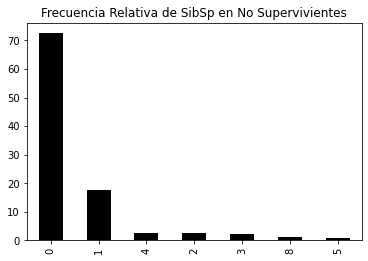

In [22]:
(100 * x0['SibSp'].value_counts() / len(x0['SibSp']))\
                .plot(kind = 'bar', 
                      title= 'Frecuencia Relativa de SibSp en No Supervivientes',
                      color = 'black')

In [25]:
# Normalidad sobre el grupo de supervivientes
x1 = df.loc[df['Survived'] == 1, ['SibSp']]
# Skew
scipy.stats.skew(x1), scipy.stats.skewtest(x1)[1], x1.median()

(array([1.94956893]), array([1.36577162e-24]), SibSp    0.0
 dtype: float64)

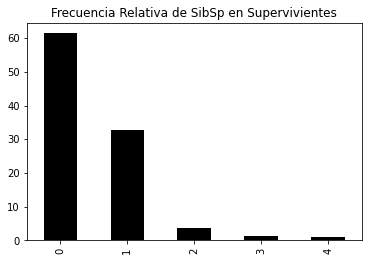

In [26]:
(100 * x1['SibSp'].value_counts() / len(x1['SibSp']))\
                .plot(kind = 'bar', 
                      title= 'Frecuencia Relativa de SibSp en Supervivientes',
                      color = 'black')

In [27]:
from math import sqrt

def cohens_d(c0,c1):
  cohens_d = (c0.mean() - c1.mean()) / (np.sqrt((c0.std() ** 2 + c1.std() ** 2) / 2))
  return cohens_d

cohens_d(x0, x1)

SibSp    0.076989
dtype: float64

In [29]:
x0 = df.loc[df['Survived'] == 0, ['Parch']]
# Skew
scipy.stats.skew(x0), scipy.stats.skewtest(x0)[1]

(array([3.31404616]), array([7.33192511e-64]))

In [30]:
x1 = df.loc[df['Survived'] == 1, ['Parch']]
# Skew
scipy.stats.skew(x1), scipy.stats.skewtest(x1)[1]

(array([1.74703141]), array([8.99394892e-22]))

In [31]:
cohens_d(x0, x1)

Parch   -0.169482
dtype: float64

**Interpretación**
>Valor absoluto|Indicador
>--- | ---
>0 | Independencia
> 0.2-0.5 | Bajo
> 0.5-0.8 | Medio
> >0.8 | Alta

## **pclassFareEmbarked**

In [0]:
# Escriba el código del par de variables 'pclassFareEmbarked' aquí

## **pclassTicketCabin**

In [0]:
# Escriba el código del par de variables 'pclassTicketCabin' aquí